# Causal Inference 

## Implementation

In [68]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Synthetic Dataset

In [69]:
np.random.seed(seed = 666)

control_size = 5000
treatment_size = 5000

age_scale = 5
age_vector_control = np.random.normal(loc = 50, scale = age_scale, size = control_size).astype(int)
age_vector_treatment = np.random.normal(loc = 40, scale = age_scale, size = control_size).astype(int)
age_vector_control

array([54, 52, 55, ..., 41, 57, 44])

In [70]:
np.random.seed(seed = 666)

#Parameters
treatment_importance = 2
age_importance = -1
noise_amount = 1
target_threshold_quantile = 0.6

# DataFrame
data = pd.DataFrame()
data["age"] = list(age_vector_control) + list(age_vector_treatment)
data["treatment"] = [0]*control_size + [1]*treatment_size
data["target_total"] = data["age"]*age_importance + data["treatment"]*treatment_importance + np.random.normal(0, scale=noise_amount, size = control_size + treatment_size)
data["target"] = (data["target_total"] >= data["target_total"].quantile(target_threshold_quantile)).astype(int)
data

,age,treatment,target_total,target
0,54,0,-53.175812,0
1,52,0,-51.520034,0
2,55,0,-53.826532,0
3,54,0,-53.090952,0
4,47,0,-47.571721,0
...,...,...,...,...
9995,42,1,-39.597842,1
9996,39,1,-37.097931,1
9997,29,1,-29.136138,1
9998,40,1,-37.982880,1


In [71]:
data.groupby(["treatment", "target"]).count()

age  target_total
treatment target                    
0         0       4930          4930
          1         70            70
1         0       1070          1070
          1       3930          3930

In [72]:
data.drop(columns=["target_total"], inplace = True)

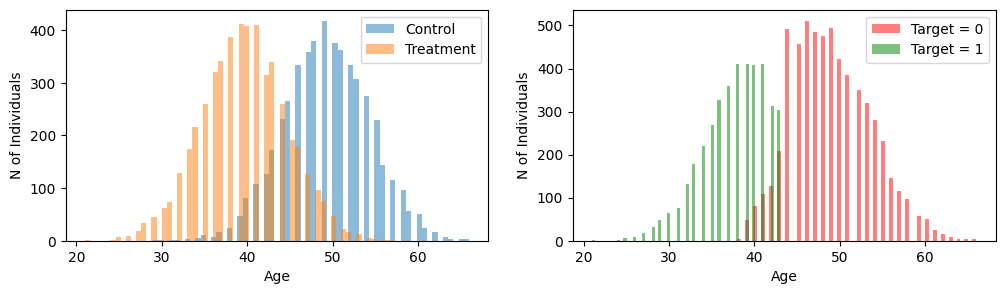

In [73]:
fig, axs = plt.subplots(1, 2, figsize = (12,3))
axs[0].hist(age_vector_control, bins = 60, alpha = 0.5, label = "Control")
axs[0].hist(age_vector_treatment, bins = 60, alpha = 0.5, label = "Treatment")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("N of Individuals")
axs[0].legend()

axs[1].hist(data.loc[data.target == 0, "age"], bins = 60, alpha = 0.5, label = "Target = 0", color = "red")
axs[1].hist(data.loc[data.target == 1, "age"], bins = 60, alpha = 0.5, label = "Target = 1", color = "green")
axs[1].set_xlabel("Age")
axs[1].set_ylabel("N of Individuals")
axs[1].legend()

plt.savefig("img/causal_inference_age_distribution.png", dpi = 300, bbox_inches='tight')
plt.show()

In [74]:
data.corr()

,age,treatment,target
age,1.000000,-0.699287,-0.789686
treatment,-0.699287,1.000000,0.787919
target,-0.789686,0.787919,1.000000


In this example, the **cofounder** "age" it's highly correlated with the treatment variable and the target variable. We have to discover the effect of the treatment on the target variable.

## Approach

### Matching 

In [75]:
data_matching = data.copy() 

control = data_matching.loc[data_matching.treatment == 0, :].copy().reset_index(drop = True)
treatment = data_matching.loc[data_matching.treatment == 1, :].copy().reset_index(drop = True)

X_control = control[["age"]].copy()
X_treatment = treatment[["age"]].copy()

In [76]:
# Fit Matching
nn_model = NearestNeighbors(n_neighbors=1).fit(X_treatment)
distances, index = nn_model.kneighbors(X_control)

control_similar = control.copy()
control_similar.rename(columns = {"age": "age_control", "control": "control_control", "target_total": "target_total_control", "target": "target_control"}, inplace = True)

treatment_similar = treatment.iloc[index.flatten()].copy().reset_index(drop = True)
treatment_similar.rename(columns = {"age": "age_treatment", "treatment": "treatment_treatment", "target_total": "target_total_treatment", "target": "target_treatment"}, inplace = True)

concated_1 = pd.concat([control_similar, treatment_similar], axis = 1)
concated_1

,age_control,treatment,target_control,age_treatment,treatment_treatment,target_treatment
0,54,0,0,54,1,0
1,52,0,0,52,1,0
2,55,0,0,55,1,0
3,54,0,0,54,1,0
4,47,0,0,47,1,0
...,...,...,...,...,...,...
4995,51,0,0,51,1,0
4996,49,0,0,49,1,0
4997,41,0,0,41,1,1
4998,57,0,0,57,1,0


In [77]:
# The closest one if it doesn't match perfectly 
concated_1.loc[concated_1.age_control != concated_1.age_treatment].head()

,age_control,treatment,target_control,age_treatment,treatment_treatment,target_treatment
61,66,0,0,57,1,0
75,58,0,0,57,1,0
99,58,0,0,57,1,0
103,59,0,0,57,1,0
109,61,0,0,57,1,0


In [78]:
# Fit Matching
nn_model = NearestNeighbors(n_neighbors=1).fit(X_control)
distances, index = nn_model.kneighbors(X_treatment)

treatment_similar = treatment.copy()
treatment_similar.rename(columns = {"age": "age_treatment", "treatment": "treatment_treatment", "target": "target_treatment"}, inplace = True)

control_similar = control.iloc[index.flatten()].copy().reset_index(drop = True)
control_similar.rename(columns = {"age": "age_control", "control": "control_control", "target": "target_control"}, inplace = True)

concated_2 = pd.concat([treatment_similar, control_similar], axis = 1)
concated_2

,age_treatment,treatment_treatment,target_treatment,age_control,treatment,target_control
0,40,1,1,40,0,0
1,44,1,0,44,0,0
2,42,1,1,42,0,0
3,41,1,1,41,0,0
4,46,1,0,46,0,0
...,...,...,...,...,...,...
4995,42,1,1,42,0,0
4996,39,1,1,39,0,0
4997,29,1,1,29,0,1
4998,40,1,1,40,0,0


In [79]:
final_dataset = pd.concat([concated_1, concated_2], axis = 0)
final_dataset = final_dataset[["age_treatment", "age_control", "target_treatment", "target_control"]]
final_dataset

,age_treatment,age_control,target_treatment,target_control
0,54,54,0,0
1,52,52,0,0
2,55,55,0,0
3,54,54,0,0
4,47,47,0,0
...,...,...,...,...
4995,42,42,1,0
4996,39,39,1,0
4997,29,29,1,1
4998,40,40,1,0


In [80]:
print(f"Treatment Effectivity {final_dataset.target_treatment.mean()*100:.2f}%")
print(f"Control Effectivity {final_dataset.target_control.mean()*100:.2f}%")

print(f"Average Treatment Effect = {final_dataset.target_treatment.mean()*100 - final_dataset.target_control.mean()*100:.2f}%") 

Treatment Effectivity 45.39%
Control Effectivity 21.53%
Average Treatment Effect = 23.86%


We can conclude that the treatment have an impact on the target variable.

### S - Model

Train a single model and use traeatment variable as input

In [81]:
X_data = data.drop(columns=["target"])
y_data = data["target"]

In [82]:
# Preprocessing 
data_mean = X_data["age"].mean()
data_std = X_data["age"].std()

X_data["age"] = (X_data["age"] - data_mean)/ data_std

# Model 
model_data = LogisticRegression(random_state=666)
model_data.fit(X_data, y_data)

LogisticRegression(random_state=666)

In [83]:
X_test = pd.DataFrame()

X_test["age"] = np.linspace(20, 65, 46)
X_test["age_normalized"] = (X_test["age"] - data_mean)/data_std

X_test_treatment = X_test.copy()
X_test_control = X_test.copy()

X_test_treatment["treatment"] = 1
X_test_control["treatment"] = 0

X_test["predicted_w_1"] = model_data.predict_proba(X_test_treatment[["age_normalized", "treatment"]].values)[:, 1]
X_test["predicted_w_0"] = model_data.predict_proba(X_test_control[["age_normalized", "treatment"]].values)[:, 1]

X_test["ITE"] = X_test["predicted_w_1"] - X_test["predicted_w_0"]
X_test.head()

/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,age,age_normalized,predicted_w_1,predicted_w_0,ITE
0,20.0,-3.490343,1.0,1.0,4.440892e-16
1,21.0,-3.347375,1.0,1.0,3.552714e-15
2,22.0,-3.204408,1.0,1.0,2.464695e-14
3,23.0,-3.061441,1.0,1.0,1.671996e-13
4,24.0,-2.918474,1.0,1.0,1.129319e-12


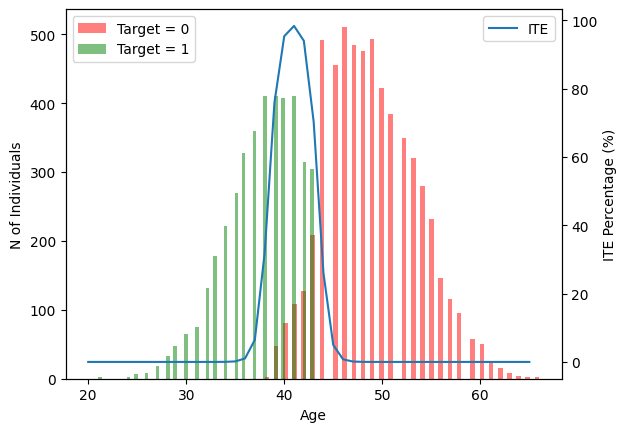

In [84]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.hist(data.loc[data.target == 0, "age"], bins = 60, alpha = 0.5, label = "Target = 0", color = "red")
ax1.hist(data.loc[data.target == 1, "age"], bins = 60, alpha = 0.5, label = "Target = 1", color = "green")
ax1.legend(loc = "upper left")
ax1.set_xlabel("Age")
ax1.set_ylabel("N of Individuals")

ax2.plot(X_test.age, X_test.ITE*100, label = "ITE (S-Model)")
ax2.set_ylabel("ITE Percentage (%)")
ax2.legend(loc = "upper right")
plt.savefig("img/causal_inference_s_model.png", dpi = 300, bbox_inches='tight')
plt.show()

### T - Model 

Train a model for each group

In [85]:
control = data.loc[data.treatment == 0].copy()
treatment = data.loc[data.treatment == 1].copy()

X_control = control.drop(columns=["target", "treatment"])
y_control = control["target"]

X_treatment = treatment.drop(columns=["target", "treatment"])
y_treatment = treatment["target"]

In [86]:
# Preprocessing 
control_mean = X_control["age"].mean()
control_std = X_control["age"].std()

treatment_mean = X_treatment["age"].mean()
treatment_std = X_treatment["age"].std()

X_control["age"] = (X_control["age"] - control_mean)/ control_std
X_treatment["age"] = (X_treatment["age"] - treatment_mean)/ treatment_std

# Model 
model_control = LogisticRegression(random_state=666)
model_control.fit(X_control, y_control)

model_treatment = LogisticRegression(random_state=666)
model_treatment.fit(X_treatment, y_treatment)

LogisticRegression(random_state=666)

In [87]:
X_test = pd.DataFrame() 
X_test["age"] = np.linspace(20, 65, 46)
X_test["age_control"] = (X_test["age"] - control_mean)/control_std
X_test["age_treatment"] = (X_test["age"] - treatment_mean)/treatment_std
X_test.head()


,age,age_control,age_treatment
0,20.0,-5.819253,-3.932428
1,21.0,-5.620675,-3.730998
2,22.0,-5.422097,-3.529569
3,23.0,-5.223519,-3.328139
4,24.0,-5.024941,-3.126710


In [88]:
X_test["predicted_model_control"] = model_control.predict_proba(X_test[["age_control"]].values)[:, 1]
X_test["predicted_model_treatment"] = model_treatment.predict_proba(X_test[["age_treatment"]].values)[:, 1]

X_test["ITE"] = X_test["predicted_model_treatment"] - X_test["predicted_model_control"]

X_test.head()

/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/nelson.moreno/anaconda3/envs/data-science/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,age,age_control,age_treatment,predicted_model_control,predicted_model_treatment,ITE
0,20.0,-5.819253,-3.932428,1.0,1.0,7.349943e-11
1,21.0,-5.620675,-3.730998,1.0,1.0,2.716265e-10
2,22.0,-5.422097,-3.529569,1.0,1.0,1.003831e-09
3,23.0,-5.223519,-3.328139,1.0,1.0,3.709788e-09
4,24.0,-5.024941,-3.126710,1.0,1.0,1.371000e-08


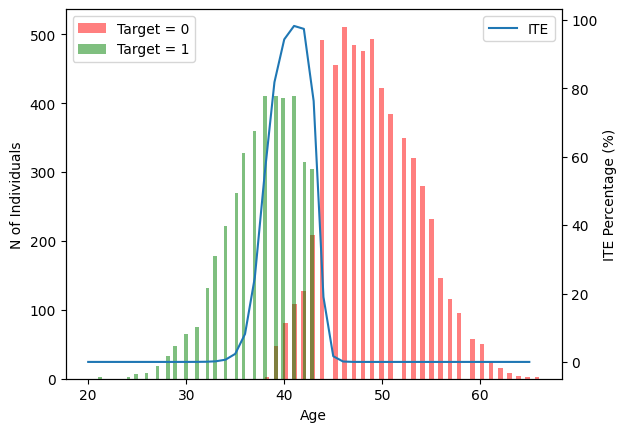

In [89]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.hist(data.loc[data.target == 0, "age"], bins = 60, alpha = 0.5, label = "Target = 0", color = "red")
ax1.hist(data.loc[data.target == 1, "age"], bins = 60, alpha = 0.5, label = "Target = 1", color = "green")
ax1.legend(loc = "upper left")
ax1.set_xlabel("Age")
ax1.set_ylabel("N of Individuals")

ax2.plot(X_test.age, X_test.ITE*100, label = "ITE (T-Model)")
ax2.set_ylabel("ITE Percentage (%)")
ax2.legend(loc = "upper right")
plt.savefig("img/causal_inference_t_model.png", dpi = 300, bbox_inches='tight')
plt.show()

### X - Model